<a href="https://colab.research.google.com/github/VhinyMombo/Boltzmann-Machine/blob/main/Copie_de_RBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Group : Vhiny Mombo & Mohamed Ennatiqi
### Graphical models
# Restricted Boltzmann machine : implementation & test on MNIST data

In [ ]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
%matplotlib inline
import matplotlib.pyplot as plt

# Introduction:

###La machine de Boltzmann a été inventée en 1985 par Geoffrey Hinton, professeur à l'université de Toronto. Il est une figure de proue de la communauté de Deep learning.

###La machine de Boltzmann est un réseau de neurones sans couche de sortie, il est composé seulement d'une couche d'entrée avec des neuronnes dits visibles et d'autres cachés formant la couche cachée du réseau, la configuration de ce réseau de neurones dans sa forme générale et de sorte que tous les neurones sont liés entre eux.

###L'RBM (pour restricted Boltzmann machine) est un type des machine de Boltzmann où on suppose de plus que les neurones de la couche d'entrée sont indépendants entre eux.

###L'RBM est un model graphique non dirigé où on observe des variables $x_i$ sachant d'autre caché $h_i$, les $x_i$ sont appelés les états visibles des neurones (par la suite on s'interesera au cas où $xi \in \{0, 1\}$).

###Les $h_i$ sont les états des neurones cachés. Le modèle est donné par la fonction d'énergie, définie comme suit ⁉
$$\mathbb{P}(x, h) = \frac{1}{Z}exp(-Energie(x, h))$$ avec  $$Energie(x, h) = \sum_ia_ix_i +\sum_ib_ih_i +\sum_iw_{ij}x_ih_i$$

###Comme on peut le remarquer, la valeur de la fonction d'énergie dépend des configurations des états visibles/entrées, des états cachés, des poids et des biais. L'apprentissage du RBM consiste à trouver des paramètres pour des valeurs d'entrée données de manière à ce que l'énergie atteigne un minimum.

![](https://drive.google.com/uc?export=view&id=13qZbhukBcPa0o3Ne7zUK3lBMJ9i1rvrA)


![](https://drive.google.com/uc?export=view&id=12p6wZDAwGxJ2ZFYkgu-ZhJQTcOW6Zf70)


# Implémentation

Pour implémenter le RBM, nous commençons par importer les données MNIST grace aux dataloader de pytorch, et nous avons choisi un batch_size = 64

In [ ]:

batch_size = 64
train_loader = torch.utils.data.DataLoader(
datasets.MNIST('./data',
    train=True,
    download = True,
    transform = transforms.Compose(
        [transforms.ToTensor()])
     ),
     batch_size=batch_size
)

test_loader = torch.utils.data.DataLoader(
datasets.MNIST('./data',
    train=False,
    transform=transforms.Compose(
    [transforms.ToTensor()])
    ),
    batch_size=batch_size)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Pour instantier le modèle RBM, nous avons créé la classe "RBM" qui prend en entrée le nombre d'état visibles "n_vis = 784", un nombre d'états cachés "n_hin = 500" et puis l'entier $k=5$ qui représente le nombre de fois de simulation pour la constructive divergence. 

### La fonction "sample_from_p" sert à simuler à partir d'une probabilité un nombre binaire. La fonction 'v_to_h' simule $h$ en fonction de $v$, en utilisant la probabilité conditionnelle $P(h/v)$, La fonction 'h_to_v' simule $v$ en fonction de $h$, en utilisant la probabilité conditionnelle $P(v/h)$ (Simulation de Gibbs)

### Pour calculer à chaque itération la CD, on utilise la fonction "forward"

In [ ]:
class RBM(nn.Module):
   def __init__(self,
               n_vis=784,
               n_hin=100,
              n_class = 10,
               k=5):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.U = nn.Parameter(torch.randn(n_class,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k
    
   def sample_from_p(self,p):
       return F.relu(torch.sign(p - Variable(torch.rand(p.size()))))
    
   def v_to_h(self,v): ### simulation de h sachant v.
        '''

        Cette fonction simule les elements de la couche cachée sachant le couche d'entrée.

        input : image sous forme vecteur ligne.
        
        outputs : 
        - p_h :  vecteur de dim 1 x n_hin vecteur contenant la probabilté 
                  que le noeud soit 1 ou 0 selon un loi de bernouilli

        -sample_h : vecteur h simulé à partir de p_h

        - p_y :  vecteur de taille 1x 10 contenant la proba de v soit 
                 le chiffre i, où i est un indice du vecteur p_y

        - sample_y : argmax(p_y)  

        '''
        p_h = torch.sigmoid(F.linear(v,self.W,self.h_bias)) # calcul de  p(h|v) = sigmoid(h_biais + v*W.T)
        sample_h = self.sample_from_p(p_h) ## simulation de h par un bernouilli de proba b

        m = nn.Softmax(dim=1)
        p_y = m(F.linear(v,self.U)) #p(pred| v) 
        sample_y = torch.argmax(p_y,1) # prediction de y sachant v
        return p_h,sample_h,p_y, sample_y
    
   def h_to_v(self,h):

      '''

        Cette fonction simule les elements de la couche entrée sachant la couche cachée.
        
        input : 
        h : vecteur de taille 1 x n_vis representant l'image sous forme vecteur ligne.
        
        outputs : 
        - p_v :  vecteur de dim 1 x n_vis contenant la probabilté 
                  que le noeud soit 1 ou 0 selon un loi de bernouilli

        -sample_v : vecteur v simulé à partir de p_v

      '''
      p_v = torch.sigmoid(F.linear(h,self.W.t(),self.v_bias))  # calcul de p(v|h) = sigmoid(h_biais + v*W.T)
      sample_v = self.sample_from_p(p_v)  ## simulation de h par un bernouilli de proba p(v|h)
      return p_v,sample_v
        
   def forward(self,v): 
     '''
     Cette fonction realise la k contrastive divergence.
     qui consiste à partir de v image de depart on realise des 
     gibbs sampling k fois en partant de 
     v -> h_1 -> v_2 -> ... -> h_(k-1) -> v_k

     le passage de v_i à h_i de fait par v_to_h et celui h_i à v_i

     se fait par h_to_v

     input : 
     v: image taille 1 x n_vis

     output:
     - 
     v : image taille 1 x n_vis
     v_: dernier v simulé corespondant à v_k
     p_yp :  vecteur de taille 1x 10 contenant la proba de v soit 
             le chiffre i, où i est un indice du vecteur p_y
     
     '''
     pre_h1,h1,p_yp,_ = self.v_to_h(v)
  
     h_ = h1
     for _ in range(self.k):
        pre_v_,v_ = self.h_to_v(h_)
        pre_h_,h_,p_yp,y_ = self.v_to_h(v_)
    
     return v,v_,p_yp
    
   def free_energy(self,v):
     '''
     fonction qui calcul l'energie sachant v
    
     input : 
     v : image sous forme flatten 1 x n_vis

     output :

      valeur de l'energie
     
     '''
     vbias_term = v.mv(self.v_bias)
     wx_b = F.linear(v,self.W,self.h_bias)
     hidden_term = wx_b.exp().add(1).log().sum(1)
     return (-hidden_term - vbias_term).mean()

Pour évaluer et étudier le comportement des l'algorithmes vis à vis de chaque chiffre, on crée un dictionnaire qui permet de ranger les digits
selon la classe.
les clés de ce dictionnaire Z sont des chiffres entre 0 et 9.
les valeurs associées sont des tenseurs contenant toutes les images associées à la clés.

In [ ]:
Z = {key: torch.tensor([]) for key in range(10)}
for k, (data,target) in enumerate(test_loader):
    data = Variable(data.view(-1,784))
    for i in target:
      Z[i.item()] = torch.cat((Z[i.item()],data[target == i.item(),:].view(-1,784)),0)

### Pour démarrer l'apprentissage, nous utilisons la boucle d'entrainement suivante : 

In [ ]:
rbm = RBM(k=10)
train_op = optim.SGD(rbm.parameters(),0.1)
from tqdm import tqdm
accuracy = []
accuracy_test=[]
originals = []
reconstructed = []

for epoch in tqdm(range(15), desc = "epoch"):
    loss_ = []
    loss_test = []
    acc = 0
    acc_test=0
    n = 0
    nt=0
    for k, (data,target) in enumerate(train_loader):
        data = Variable(data.view(-1,784))

        sample_data = data
        #sample_data = data.bernoulli() à revoir
        v,v1,py = rbm(sample_data)
        acc+=torch.sum(torch.argmax(py,1) == target)
        n+=target.shape[0]
        
        ## loss sur les predictions
        nll_loss = nn.NLLLoss()
        loss_pred = nll_loss(py, target)
        
        ## loss 
        loss = rbm.free_energy(v)-rbm.free_energy(v1) +  loss_pred
        loss_.append(loss.data)

        ### update des poids 
        train_op.zero_grad()
        loss.backward()
        train_op.step()

        if k==1:
          reconstructed.append(v)
          originals.append(v1)

    with torch.no_grad(): #jeu de validation
      for _,(data, target) in enumerate(test_loader):
        data = Variable(data.view(-1,784))
        vt,vt1,pred = rbm(data)
        acc_test+=torch.sum(torch.argmax(pred,1) == target)
        nt+=target.shape[0]
        nll_loss_test = nn.NLLLoss()
        loss_pred_test = nll_loss_test(pred, target)
        loss_t= rbm.free_energy(vt)-rbm.free_energy(vt1) +  loss_pred_test
        loss_test.append(loss_t.data)



    print("\nAccuracy train {}".format(acc/n))
    print("Accuracy test {}".format(acc_test/nt))
    
    accuracy += [acc/n]
    accuracy_test += [acc_test/nt]
    
    print("Training loss train for {} epoch: {}".format(epoch+1, np.mean(loss_)))
    print("Training loss test for {} epoch: {}".format(epoch+1, np.mean(loss_test)))

epoch:   7%|▋         | 1/15 [00:35<08:10, 35.02s/it]


Accuracy train 0.32659998536109924
Accuracy test 0.4643000066280365
Training loss train for 1 epoch: -12.832389831542969
Training loss test for 1 epoch: -5.139074802398682


epoch:  13%|█▎        | 2/15 [01:08<07:23, 34.10s/it]


Accuracy train 0.5710166692733765
Accuracy test 0.6195999979972839
Training loss train for 2 epoch: -9.769828796386719
Training loss test for 2 epoch: -6.051756381988525


epoch:  20%|██        | 3/15 [01:41<06:42, 33.52s/it]


Accuracy train 0.6592000126838684
Accuracy test 0.6858000159263611
Training loss train for 3 epoch: -8.072698593139648
Training loss test for 3 epoch: -5.882958889007568


epoch:  27%|██▋       | 4/15 [02:14<06:05, 33.22s/it]


Accuracy train 0.6850833296775818
Accuracy test 0.694599986076355
Training loss train for 4 epoch: -7.024444103240967
Training loss test for 4 epoch: -2.8789658546447754


epoch:  33%|███▎      | 5/15 [02:46<05:30, 33.06s/it]


Accuracy train 0.6918833255767822
Accuracy test 0.694599986076355
Training loss train for 5 epoch: -6.030762672424316
Training loss test for 5 epoch: -3.9097561836242676


epoch:  40%|████      | 6/15 [03:21<05:01, 33.50s/it]


Accuracy train 0.6962666511535645
Accuracy test 0.6869000196456909
Training loss train for 6 epoch: -5.074896335601807
Training loss test for 6 epoch: -0.49958738684654236


epoch:  47%|████▋     | 7/15 [03:54<04:26, 33.29s/it]


Accuracy train 0.6996999979019165
Accuracy test 0.7027999758720398
Training loss train for 7 epoch: -4.287567615509033
Training loss test for 7 epoch: -2.0413782596588135


epoch:  53%|█████▎    | 8/15 [04:26<03:51, 33.04s/it]


Accuracy train 0.7021166682243347
Accuracy test 0.7073000073432922
Training loss train for 8 epoch: -3.7547144889831543
Training loss test for 8 epoch: -2.4519600868225098


epoch:  60%|██████    | 9/15 [04:59<03:18, 33.02s/it]


Accuracy train 0.7061333060264587
Accuracy test 0.7062000036239624
Training loss train for 9 epoch: -3.4312469959259033
Training loss test for 9 epoch: -1.5481878519058228


epoch:  67%|██████▋   | 10/15 [05:32<02:44, 32.89s/it]


Accuracy train 0.7053333520889282
Accuracy test 0.7056999802589417
Training loss train for 10 epoch: -3.1123478412628174
Training loss test for 10 epoch: -1.6340662240982056


epoch:  73%|███████▎  | 11/15 [06:05<02:11, 32.91s/it]


Accuracy train 0.7096166610717773
Accuracy test 0.70660001039505
Training loss train for 11 epoch: -2.8099353313446045
Training loss test for 11 epoch: -1.2257524728775024


epoch:  80%|████████  | 12/15 [06:38<01:38, 32.92s/it]


Accuracy train 0.7093166708946228
Accuracy test 0.7120000123977661
Training loss train for 12 epoch: -2.6751210689544678
Training loss test for 12 epoch: -2.392909526824951


epoch:  87%|████████▋ | 13/15 [07:12<01:06, 33.44s/it]


Accuracy train 0.7104166746139526
Accuracy test 0.7056999802589417
Training loss train for 13 epoch: -2.565385103225708
Training loss test for 13 epoch: -1.3643345832824707


epoch:  93%|█████████▎| 14/15 [07:46<00:33, 33.41s/it]


Accuracy train 0.7198500037193298
Accuracy test 0.7283999919891357
Training loss train for 14 epoch: -2.4081063270568848
Training loss test for 14 epoch: -1.6795895099639893


epoch: 100%|██████████| 15/15 [08:18<00:00, 33.26s/it]


Accuracy train 0.739300012588501
Accuracy test 0.743399977684021
Training loss train for 15 epoch: -2.33243989944458
Training loss test for 15 epoch: -2.305043935775757


### Dans le code ci-dessus, nous faisons la reconstruction des images v et en regarde en même temps la prédiction de ce qui a été reconstruit.

### Pour monitorer l'évolution de cet apprentissage, nous gardons l'accuracy et les losses pour les ploter après.

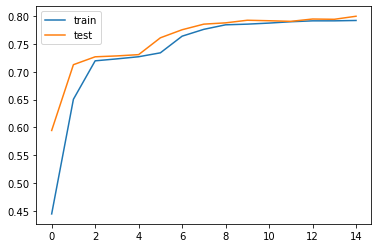

In [ ]:
plt.plot(accuracy)
plt.plot(accuracy_test)
plt.legend(['train', 'test'])
plt.show()

In [ ]:
def show_adn_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.show()

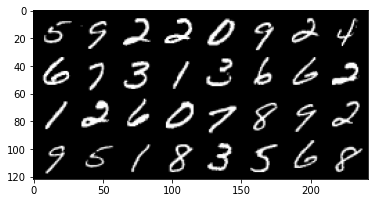

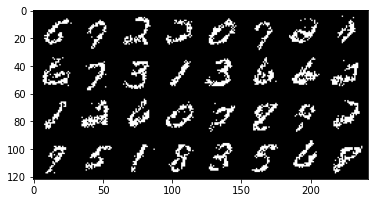

In [ ]:
show_adn_save("real",make_grid(v[:,0:784].view(32,1,28,28).data))
show_adn_save("generate",make_grid(v1[:,0:784].view(32,1,28,28).data))

### Pour bien visualiser la qualité de la reconstruction, on plot les images dans chaque epoch, et là nous allons voir que le modèle apprend bien les bons patterns qui caractérise chaque classe (chiffre de 0 à 9).   

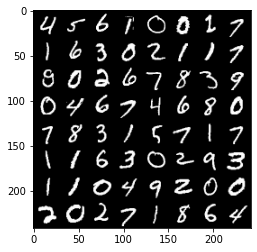

________________________
________________________


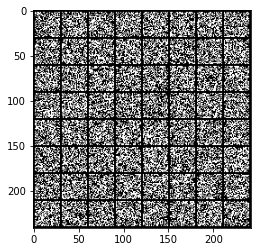

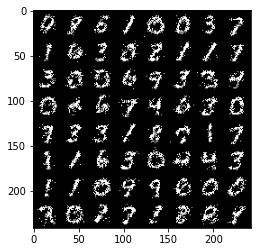

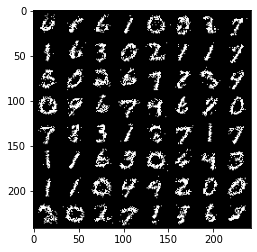

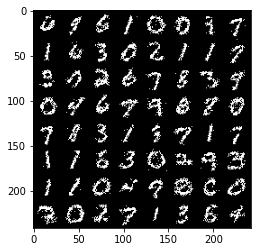

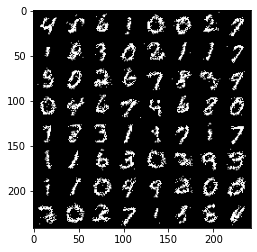

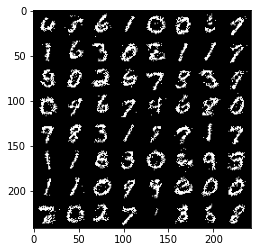

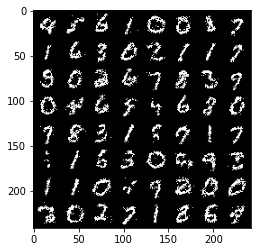

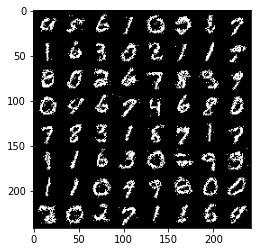

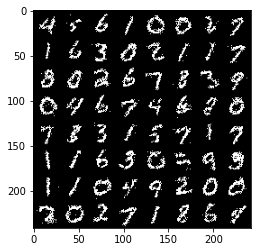

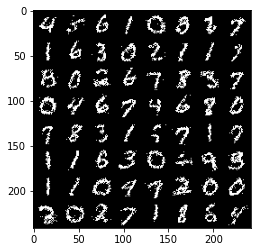

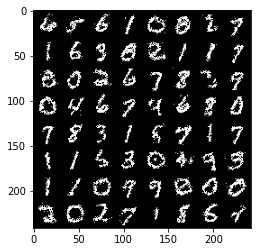

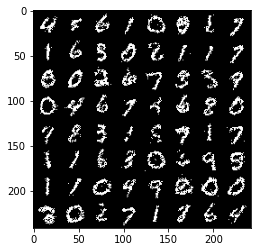

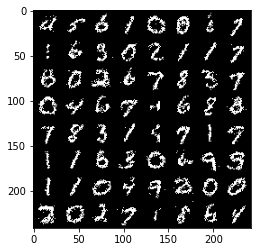

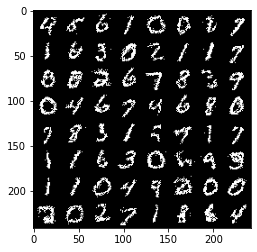

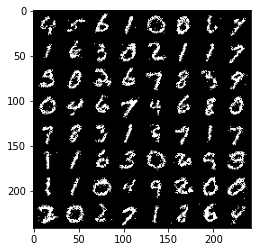

In [ ]:
show_adn_save("generate",make_grid(reconstructed[0][:,0:784].view(64,1,28,28).data))
print("________________________")
print("________________________")

for i in range(15):
  show_adn_save("real",make_grid(originals[i][:,0:784].view(64,1,28,28).data))


#### **Matrice de poids W et U**

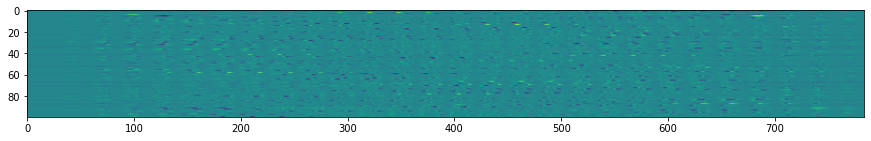

In [ ]:
plt.figure(figsize=(15, 9))
plt.imshow(rbm.W.detach())
plt.show()

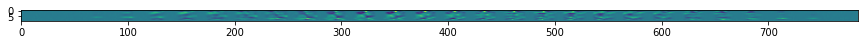

In [ ]:
plt.figure(figsize=(15, 60))
plt.imshow(rbm.U.detach())
plt.show()

In [ ]:
rbm.W

Parameter containing:
tensor([[-0.3548, -0.3980, -0.3784,  ..., -0.3470, -0.3695, -0.3608],
        [-0.3660, -0.3470, -0.3477,  ..., -0.3399, -0.3525, -0.3391],
        [-0.2859, -0.2726, -0.2947,  ..., -0.2677, -0.2707, -0.2594],
        ...,
        [-0.4086, -0.4402, -0.4280,  ..., -0.4441, -0.4255, -0.4604],
        [-0.4934, -0.4927, -0.4635,  ..., -0.4664, -0.4637, -0.4959],
        [-0.2539, -0.2972, -0.2819,  ..., -0.2429, -0.2352, -0.2444]],
       requires_grad=True)

In [ ]:
rbm.U

Parameter containing:
tensor([[ 0.0066,  0.0059, -0.0035,  ...,  0.0049,  0.0020, -0.0005],
        [ 0.0083, -0.0167,  0.0006,  ..., -0.0149, -0.0040, -0.0093],
        [ 0.0135, -0.0030, -0.0095,  ..., -0.0021,  0.0027,  0.0077],
        ...,
        [-0.0053,  0.0091,  0.0160,  ...,  0.0004, -0.0081, -0.0128],
        [-0.0038, -0.0152, -0.0112,  ..., -0.0149, -0.0057,  0.0271],
        [-0.0134,  0.0029,  0.0036,  ...,  0.0064,  0.0057,  0.0190]],
       requires_grad=True)

### Dans les plots ci-dessous, on essaie de visualiser la représentation des images du dernier batch dans l'espace des neurones cachés $h_i$ (v_to_h), et le code couleur (en gradient du rouge) représente les probabilités $P(h/v)$. Dans le deuxième plot, on visualise une simulation de $h$ sachant $v$ (avec une loi de Bernoulli).

### La dégradation de l'image reconstruite est due au probabilités intermédiaires ($les. p_i \in ]0,1[$)), ce qui laisse la possibilité de simuler des pixels abérants (dont la valeur simulée est différente de la valeur réelle).

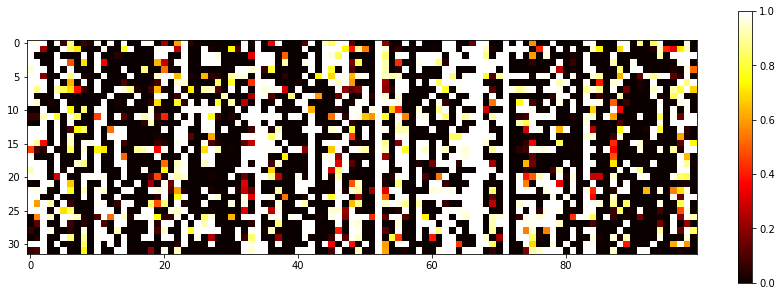

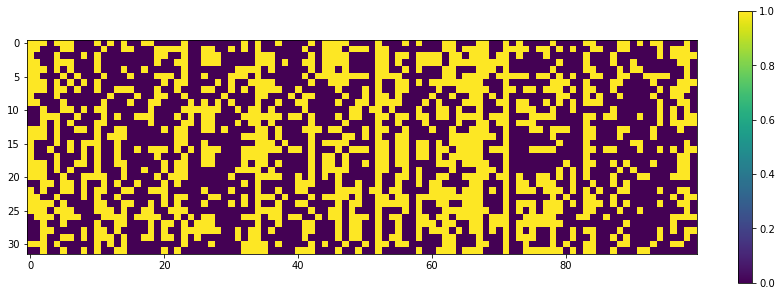

In [ ]:
plt.figure(figsize=(15,5))
plt.imshow(rbm.v_to_h(v1)[0].detach(), cmap = "hot")
plt.colorbar()
plt.show()

plt.figure(figsize=(15,5))
plt.imshow(rbm.v_to_h(v1)[1].detach())
plt.colorbar()
plt.show()


### Visualisation des donneés dans l'espace des noeuds cachés.

Pour mieux visualiser le comportements des neurones cachés dans le cas où on simule le chiffre "1" comparé au chiffre "5" (deux chiffres qui s'écrivent différament). Nous allons représenter les probabilités pour simuler ses deux chiffres :

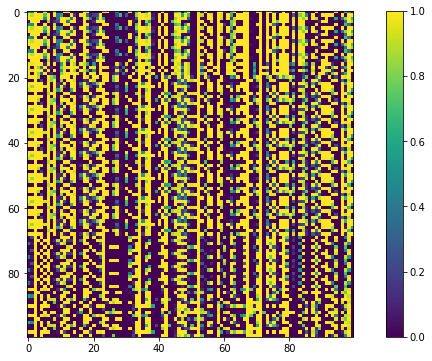

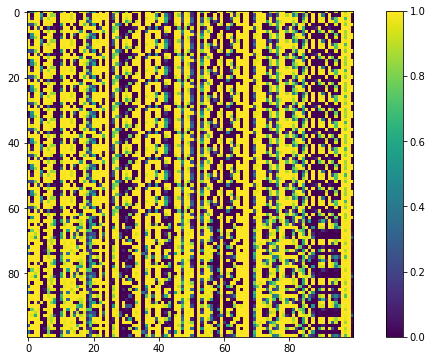

In [ ]:
plt.figure(figsize=(12,6))
plt.imshow(rbm.v_to_h(Z[5])[0].detach()[:100])
plt.colorbar()


plt.figure(figsize=(12,6))
plt.imshow(rbm.v_to_h(Z[1])[0].detach()[:100])
plt.colorbar()



```
# This is formatted as code
```

### Nous pouvons facilement remarquer des patterns qui caractérisent la forme de chaque chiffre !

### **Prédictions**
Pour analyser la capacité du modèles de prediction on affiche le vecteur de probabilité d'appartenance à chaque classe pour différents chiffres

Accuracy sur la prediction des images de label 5 est :  0.5020610094070435


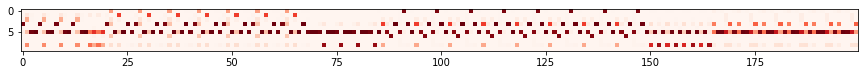

In [ ]:
k = 5 ### chiffre dont on veut voir la probabilte d'appartenance, nombre entre 0-9
plt.figure(figsize=(15,6))
plt.imshow(rbm.v_to_h(Z[k])[2].detach()[:200].T, cmap = 'Reds')

print(f'Accuracy sur la prediction des images de label {k} est :  {(torch.argmax(rbm.v_to_h(Z[k])[2],1) == k).sum()/Z[k].shape[0]}')

#### **Les images de 5 dont les indices sont entre 20 et 70 conduisent à des  mauvaises classifications. Ceci est peut du à la manière dont ils sont écrits.**

On peut voir cela ci dessous : 

In [ ]:
np.random.randint(5,10)

5

23
valeur predite :  1
valeur réelle :  5


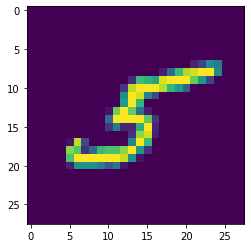

In [ ]:
k = 5 #nombre que veut étudier

#i = np.random.randint(Z[k].shape[0])
i = np.random.randint(15,60) #prend un indice aleatoirement entre 20 et 70 pour comprendre pourquoi ils sont mal prédits
print(i)
plt.imshow(Z[k][i,:].view(28,28).detach())
print(f'valeur predite :  {torch.argmax(rbm.v_to_h(Z[k][i,:].view(-1, 784))[2])}')
print(f'valeur réelle :  {k}')
plt.show()